Credit: Jared

### Problem 9.2: Outliers in FRET binding curve, 20 pts

We often want to ascertain how tightly two proteins are bound by measuring their dissociation constant, $K_d$.  This is usually done by doing a titration experiment and then performing a regression.  For example, imagine two proteins, a and b may bind to each other in the reaction

\begin{align}
\text{ab} \rightleftharpoons \text{a} + \text{b}
\end{align}

with dissociation constant $K_d$.  At equilibrium

\begin{align}
K_d = \frac{c_a\,c_b}{c_{ab}},
\end{align}

were $c_i$ is the concentration of species $i$.  If we add known amounts of a and b to a solution such that the total concentration of a is $c_a^0$ and the total concentration of b is $c_b^0$, we can compute the equilibrium concentrations of all species.  Specifically, in addition to the equation above, we have conservation of mass equations,

\begin{align}
c_a^0 &= c_a + c_{ab}\\[1em]
c_b^0 &= c_b + c_{ab},
\end{align}

fully specifying the problem.  We can solve the three equations for $c_{ab}$ in terms of the known quantities $c_a^0$ and $c_b^0$, along with the parameter we are trying to measure, $K_d$.  We get

\begin{align}
c_{ab} = \frac{2c_a^0\,c_b^0}{K_d+c_a^0+c_b^0 + \sqrt{\left(K_d+c_a^0+c_b^0\right)^2 - 4c_a^0\,c_b^0}}.
\end{align}

The technique, then, is to hold $c_a^0$ fixed in the experiment and measure $c_{ab}$ for various $c_b^0$. We can then perform a regression to get $K_d$.

In order to do this, though, we need some readout of $c_{ab}$. For this problem, we will use FRET (fluorescence resonance energy transfer) to monitor how much of a is bound to b.  Specifically, we consider a to have a fluorophore and b to be its receptor.  When the two are unbound, we get a fluorescence signal per molecule of $f_0$.  When they are bound, the receptor absorbs the light coming out of the fluorophore, so we get less fluorescence per molecule, which we will call $f_q$ (for "quenched").  Let $f$ be the total per-fluorophore fluorescence signal.  Then, the measured fluorescence signal, $F$, is

\begin{align}
F = c_a^0\,V f = \left(c_a \,f_0 + c_{ab}\, f_q\right)V,
\end{align}

where $V$ is the reaction volume. We can absorb $V$ into the other parameters such that $\hat{f}_0 = f_0 V$ and $\hat{f}_q = f_q V$, giving

\begin{align}
F = \hat{f}_0(c_a^0 - c_{ab}) + \hat{f}_q\, c_{ab}
= \hat{f}_0\,c_a^0 - \frac{2(\hat{f}_0 - \hat{f}_q)c_a^0\,c_b^0}{K_d+c_a^0+c_b^0 + \sqrt{\left(K_d+c_a^0+c_b^0\right)^2 - 4c_a^0\,c_b^0}}.
\end{align}

Compute parameter estimates for $K_d$ with and without an outlier detection scheme for [this data set](../data/fret_binding_curve.csv). How do the results differ depending on whether or not you were trying to detect outliers?

*Note*: These are real data, but they are from an unpublished experiment here on campus. I therefore have not exposed the identities of the proteins a and b.

In [1]:
import glob
import os
import sys

import numpy as np
import pandas as pd
import scipy.signal

# Import Altair for high level plotting
import altair as alt
import altair_catplot as altcat

# Pevent bulky altair plots
alt.data_transformers.enable('json')

import bebi103
import bokeh
from bokeh.palettes import all_palettes
import itertools
from bokeh.models import Legend, LegendItem
bokeh.io.output_notebook()

Loading BokehJS ...

First let's read in the data:

In [2]:
df = pd.read_csv("../data/fret_binding_curve.csv", comment = '#')
df

buffer  fluorescence  a conc (nM)  b conc (nM)
0  1256.5751   258316.2818         50.0  1500.000000
1  1256.5751   267722.6277         50.0   750.000000
2  1256.5751   267431.6620         50.0   375.000000
3  1256.5751   284596.2914         50.0   187.500000
4  1256.5751   254903.3958         50.0    93.750000
5  1256.5751   333810.6371         50.0    46.875000
6  1256.5751   370821.7778         50.0    23.437500
7  1256.5751   408856.1424         50.0    11.718750
8  1256.5751   431000.0000         50.0     5.859375
9  1256.5751   437000.0000         50.0     0.000000

And take a look:

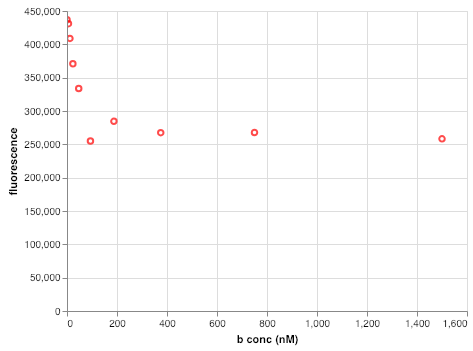

In [3]:
plot1 = alt.Chart(df).mark_point(color='red').encode(
        x = alt.X("b conc (nM)"),
        y = alt.Y("fluorescence")
        ).interactive()
plot1

Hmmm I wonder if there are any outliers haha.

Given our known quantities and our goal, the relevant equation is:
\begin{align}
F
= \hat{f}_0\,c_a^0 - \frac{2(\hat{f}_0 - \hat{f}_q)c_a^0\,c_b^0}{K_d+c_a^0+c_b^0 + \sqrt{\left(K_d+c_a^0+c_b^0\right)^2 - 4c_a^0\,c_b^0}}.
\end{align}

The concentration of a is a set quantity in this experiment and that of b is our independent variabl, so we need parameter estimates of $K_d$, $\hat{f}_0$, and $\hat{f}_q$. Additionally we want to include a Gaussian error term $\sigma$ to reflect errors in measurement. Our priors are as follows:

$$\text{fl} ~ \text{Norm}(F(c_a^0), \sigma).$$ 

Thus we expect the observed flourescence to be gaussian distributed around the value predicted by the equatin.

$K_d = e^{\Delta g/RT}$ This is the definition of $K_d$ in terms of $\Delta_g$

$\Delta G/RT$ ~ Norm(0, 1) We're not certain what to expect with the $\Delta_g$ values, whether they will be positive or negative, so we will approximate them (normalized with the gas constant and the temperature) to be normally distributed around 0.

$\hat{f}_0$ ~ Norm(10000, 1000) Flourescence is an ununited relative value, but in this experiment it appears to be between 100000 and 500000. Since $F= \hat{f}_0\,c_a^0$, we expect the highest fluorescence value to be $50*\hat{f}_0$ so we will choose a distribution with a wide variation at the top of this scale.

$\hat{f}_q$ ~ Norm(5000, 500) We expect quenched molecules to have a much smaller fluorescence than the unquenched molecules, so we will choose a distribution half that of $\hat{f}_0$

$\sigma$ ~ Half-Norm(0, 5000): The standard deviation of the Gaussian distribution of the measurments.
Additionally, we know that 
$c_a^0$ = 50 nM
And we know that $c_b^0$ is given by the values in the dataframe:

In [4]:
data = dict(N=len(df),
           cb=df['b conc (nM)'].values.astype(float))

We code this up into a prior predictive check

In [5]:
sm = bebi103.stan.StanModel(file='./9.2_prior.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d13e050bd21d9d0b70778c0e89c4e718 NOW.
/Users/jaredlivingston/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/w3/tn6brvj12bx95d_v766ht54h0000gn/T/tmpmmps_zhr/stanfit4anon_model_d13e050bd21d9d0b70778c0e89c4e718_4864675801280347423.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


We do our sampling and load the samples into a dataframe:

In [6]:
samples = sm.sampling(data=data, algorithm="Fixed_param",
                          warmup=0,
                          chains=1,
                          iter=1000)
df_gen = bebi103.stan.to_dataframe(samples, diagnostics=False)

/Users/jaredlivingston/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


We use dataframe methods to look at the fluorescence values for each sample

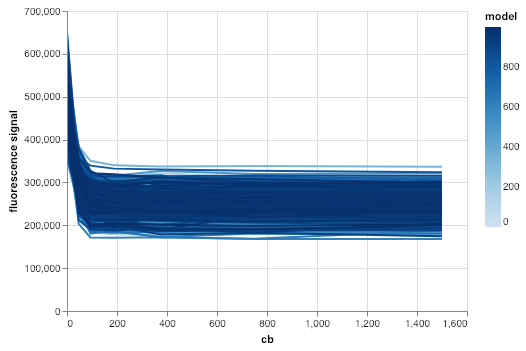

In [7]:
# Define the columns we want to take out
cols = ["fl[1]", "fl[2]", "fl[3]", "fl[4]", "fl[5]",
        "fl[6]", "fl[7]", "fl[8]", "fl[9]", "fl[10]"]
# Take out the columns
df_gen_fl = df_gen[cols]
# Reindex
df_gen_fl = df_gen_fl.stack(level=0)
df_gen_fl = df_gen_fl.reset_index()
df_gen_fl = df_gen_fl.sort_index(level=1)


# Renaming the columns with useful names
df_gen_fl = df_gen_fl.rename(columns={'level_0': 'model', 
                                  'level_1': 'cb',
                                  0:'fluorescence signal'})

# Renaming the conditions with more descriptive names
for i in range(len(cols)):
    df_gen_fl = df_gen_fl.replace({cols[i]:data['cb'][i]})
    
# Take a look
alt.Chart(df_gen_fl).mark_line().encode(
    x = alt.X('cb'),
    y = alt.Y('fluorescence signal'),
    color = alt.Color('model')).interactive()


This looks good! The flourescence values appear to be how we would expect them, in the correct order of magnitude and dependent on cb. Let's code this up into a stan model:

In [8]:
sm2 = bebi103.stan.StanModel(file='./9.2_model.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_376ec8ecc2875821c33278e039761928 NOW.
/Users/jaredlivingston/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/w3/tn6brvj12bx95d_v766ht54h0000gn/T/tmpy0mx_s93/stanfit4anon_model_376ec8ecc2875821c33278e039761928_8007411489730510917.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Load up our data and sample:

In [9]:
data = dict(N=len(df),
           cb=df['b conc (nM)'].values.astype(float),
           fl=df['fluorescence'].values.astype(float))
samples2 = sm2.sampling(data=data, 
                       control=dict(adapt_delta = .9999999,
                                    max_treedepth = 12),
                       warmup=2000, 
                       iter=10000, 
                       thin=5)
bebi103.stan.check_all_diagnostics(samples2)

n_eff / iter looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0.0 of 6400 (0.0%) iterations ended with a divergence.
0 of 6400 (0.0%) iterations saturated the maximum tree depth of 12.
E-BFMI indicated no pathological behavior.


0

That looks like it worked fine, so let's load it up into a dataframe and take a look:

In [10]:
dfmcmc = bebi103.stan.to_dataframe(samples2, diagnostics=False, inc_warmup=False)
dfmcmc.head()

chain  chain_idx  warmup   Delta_G           f0           fq         sigma  \
0      1          1       0  0.973592  8966.159587  4451.966647  14839.580975   
1      1          2       0 -0.397778  8714.786790  4801.447149  16397.724055   
2      1          3       0  0.531467  8869.347767  4843.826440  17902.073757   
3      1          4       0  1.145375  8711.667633  4914.528543  13924.937763   
4      1          5       0  1.065030  8779.968841  4798.585114  18924.916618   

         Kd           F[1]           F[2]     ...          fl_ppc[2]  \
0  2.647437  230251.734013  237403.131989     ...      272979.626656   
1  0.671811  246466.231520  252455.458938     ...      265552.818765   
2  1.701426  248897.676392  255171.540473     ...      250496.211869   
3  3.143619  252222.726324  258289.168564     ...      253326.715794   
4  2.900926  246710.721344  253045.374950     ...      189004.701665   

       fl_ppc[3]      fl_ppc[4]      fl_ppc[5]      fl_ppc[6]      fl_ppc[7]  \
0  271210.777595  259770.296457  316757.417853  361476.099494  406035.827039   
1  252824.080490  269510.412080  327590.944085  341788.725007  375857.337554   
2  285240.388523  253130.659595  317615.918031  336730.205168  361035.123631   
3  269460.412284  266757.239312  327911.471455  353903.404035  367796.942613   
4  263469.010626  277844.590764  298679.085787  362228.572867  372783.250940   

       fl_ppc[8]      fl_ppc[9]     fl_ppc[10]        lp__  
0  430111.730605  448151.571666  433648.114995 -103.427365  
1  418360.673733  391189.266401  447263.464454 -100.599445  
2  387997.404100  420934.794110  450835.610644 -101.791404  
3  400033.321572  422446.398065  436650.172318 -101.956250  
4  381438.789957  433285.866881  426485.222993 -102.711542  

[5 rows x 39 columns]

Let's check the corner plot to make sure everything looks the way we would expect:

In [11]:
bokeh.io.show(bebi103.viz.corner(samples2,
                                        pars=['Delta_G', 'f0', 'fq','sigma']))

/Users/jaredlivingston/anaconda3/lib/python3.6/site-packages/bebi103/viz.py:2575: UserWarning: Rendering so many points without DataShader is ill-advised.
  'Rendering so many points without DataShader is ill-advised.')


Let's look at the posterior predictive check to verify our model is doing what we think:

In [12]:
p = bebi103.viz.predictive_ecdf(samples2,
                                name='fl_ppc', 
                                data=df["fluorescence"],
                                x=np.linspace(200000, 500000),
                                percentiles=[99, 80, 60, 40])
p.plot_width=800

bokeh.io.show(p)

This looks good, but because we lose the cb information in the ECDF format I'd like to also plot the fluorescence values predicting in the posterior predictive checks against the cb values:

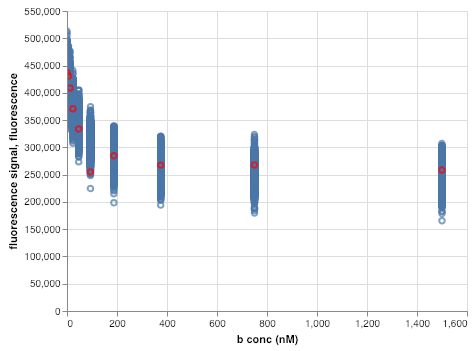

In [13]:
def check_ppc(df):
    # Define the columns we want to take out
    cols = ["fl_ppc[1]", "fl_ppc[2]", "fl_ppc[3]", "fl_ppc[4]", "fl_ppc[5]",
            "fl_ppc[6]", "fl_ppc[7]", "fl_ppc[8]", "fl_ppc[9]", "fl_ppc[10]"]
    # Take out the columns
    df_fl = df[cols]
    # Reindex
    df_fl = df_fl.stack(level=0)
    df_fl = df_fl.reset_index()
    df_fl = df_fl.sort_index(level=1)


    # Renaming the columns with useful names
    df_fl = df_fl.rename(columns={'level_0': 'model', 
                                  'level_1': 'cb',
                                  0:'fluorescence signal'})

    # Renaming the conditions with more descriptive names
    for i in range(len(cols)):
        df_fl = df_fl.replace({cols[i]:data['cb'][i]})
    
    # Take a look
    plot2 = alt.Chart(df_fl).mark_point().encode(
            x = alt.X('cb', title = "b conc (nM)"),
            y = alt.Y('fluorescence signal')).interactive()
    return plot2 + plot1

check_ppc(dfmcmc)

This looks pretty good. We're getting a wide variation around each of the points, likely due to the model trying to catch the outlier. Let's now estimate the Kd from this model:

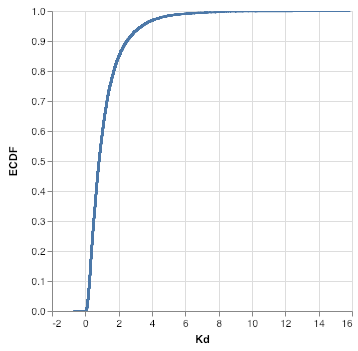

In [14]:
# First let's make a helper plotting function
def make_ecdf(dataframe, data):
    c = altcat.catplot(data=dataframe,
               mark='line',
               encoding=dict(x=alt.X(data,
                                     scale=alt.Scale(
                                           clamp=True))),
               transform='ecdf'
              ).properties(height=300,
                           width=300).interactive()
    return c
# And now apply it
make_ecdf(dfmcmc, "Kd:Q")

This doesn't look like the mean would be a good statistic, so instead let's report the median.

In [15]:
Kd = dfmcmc["Kd"].median() 
Kd

0.8237222254654333

Now let's attempt to deal with the outliers. We will start by using the student t model. The only difference between this model and our original is that we have our data distributed using the student t distribution instead of the Gaussian distribution, so 
$$\text{fl}~ \text{Student_t}(\nu, F(c_a^0), \sigma).$$ 

Where
$\nu$ ~ HalfNorm(1,100), since $\nu$ is bounded by 1 at the bottom and corresponds to how Gaussian the distribution is.

Let's load up this stan model:

In [16]:
sm3 = bebi103.stan.StanModel(file='./9.2_student_model.stan')

Using cached StanModel.


And sample:

In [17]:
samples3 = sm3.sampling(data=data, 
                       control=dict(adapt_delta = .9999999,
                                    max_treedepth = 12),
                       warmup=2000, 
                       iter=10000, 
                       thin=5)
bebi103.stan.check_all_diagnostics(samples3)

/Users/jaredlivingston/anaconda3/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


n_eff / iter looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0.0 of 6400 (0.0%) iterations ended with a divergence.
0 of 6400 (0.0%) iterations saturated the maximum tree depth of 12.
E-BFMI indicated no pathological behavior.


0

Diagnostics look good, let's load this into a dataframe and take a look:

In [18]:
df_student = bebi103.stan.to_dataframe(samples3, diagnostics=False, inc_warmup=False)
df_student.head()

chain  chain_idx  warmup   Delta_G           f0           fq         sigma  \
0      1          1       0 -0.938641  8849.223540  4912.866269   7230.118955   
1      1          2       0 -1.790540  8616.809832  4723.771126  12005.837645   
2      1          3       0 -1.228142  8664.853690  4858.332251  12569.496936   
3      1          4       0 -1.182514  8839.534371  5011.304223   7607.666965   
4      1          5       0 -0.909646  8856.838588  4879.008891   9705.743905   

         nu        Kd           F[1]     ...          fl_ppc[2]  \
0  1.827295  0.391159  252040.331540     ...      261650.711671   
1  6.019750  0.166870  242487.928650     ...      251872.632759   
2  4.442519  0.292836  249090.954424     ...      243337.620592   
3  4.063967  0.306507  256776.398629     ...      261476.674766   
4  6.190695  0.402667  250416.288218     ...      270966.179288   

       fl_ppc[3]      fl_ppc[4]      fl_ppc[5]      fl_ppc[6]      fl_ppc[7]  \
0    9595.681559  289416.395208  325591.897279  341081.138192  396089.320444   
1  268671.367804  271411.423248  317981.016878  350195.110913  378367.642969   
2  265014.916131  276798.580015  310588.388432  322990.090914  355777.333264   
3  265617.952428  294047.832415  305648.367100  347416.020743  362174.260157   
4  279439.785730  284212.897121  312673.742819  344361.859307  361571.228751   

       fl_ppc[8]      fl_ppc[9]     fl_ppc[10]        lp__  
0  440931.741840  422936.270922  444503.389835  -97.722763  
1  384502.737061  404948.244603  422293.972910 -102.081857  
2  396320.017135  416037.119271  440213.672347  -99.751650  
3  403515.541874  412543.597017  449576.904786  -98.107322  
4  397684.898523  415995.812082  437599.208030  -97.981167  

[5 rows x 30 columns]

And take a look at the parameters:

In [19]:
bokeh.io.show(bebi103.viz.corner(samples3,
                                        pars=['Delta_G', 'f0', 'fq','sigma', 'nu']))

/Users/jaredlivingston/anaconda3/lib/python3.6/site-packages/bebi103/viz.py:2575: UserWarning: Rendering so many points without DataShader is ill-advised.
  'Rendering so many points without DataShader is ill-advised.')


This looks as expected, so let's take a look at our posterior predictive checks:

In [20]:
p = bebi103.viz.predictive_ecdf(samples3,
                                name='fl_ppc', 
                                data=df["fluorescence"],
                                x=np.linspace(200000, 500000),
                                percentiles=[99, 80, 60, 40])
p.plot_width=800

bokeh.io.show(p)

This seems to fit our values pretty well but let's take a look at the fluorescence values vs the b concentration:

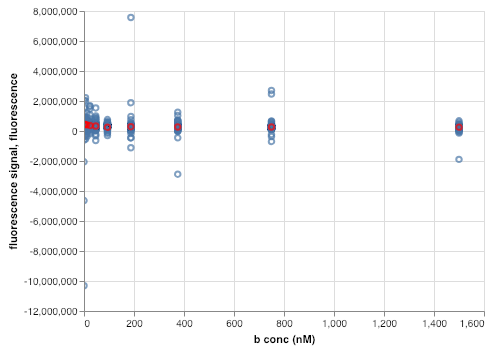

In [21]:
check_ppc(df_student)

This model is generating a lot of outliers to compensate for those in our data set. Let's compare the Kd values for this model and our original:

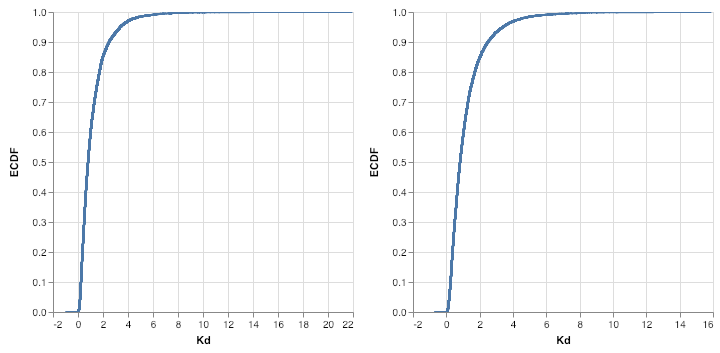

In [22]:
make_ecdf(df_student, "Kd:Q") | make_ecdf(dfmcmc, "Kd:Q")

These look rather similar. Let's compute the median:

In [23]:
Kd2 = df_student["Kd"].median() 
Kd2


0.806085397732135

Finally, let's use a Good/Bad model for outlier detection and see what effect that has. We thus use a mixture model in which each data point has a probability $w_i$ of being good, with error bar $\sigma$, and otherwise has error bar $\sigma_bad$>$\sigma$. Both of our sigmas will be pulled from the same distribution (HalfNorm(0,5000)) we used in previous models, and our

$w_i$ ~ Beta(2,5)

Let's load up the model:

In [24]:
sm4 = bebi103.stan.StanModel(file='./9.2_good_model.stan')

Using cached StanModel.


And sample:

In [25]:
samples4 = sm4.sampling(data=data, 
                       control=dict(adapt_delta = .9999999,
                                    max_treedepth = 12),
                       warmup=2000, 
                       iter=10000, 
                       thin=5)
bebi103.stan.check_all_diagnostics(samples4)

n_eff / iter looks reasonable for all parameters.
Rhat looks reasonable for all parameters.
0.0 of 6400 (0.0%) iterations ended with a divergence.
0 of 6400 (0.0%) iterations saturated the maximum tree depth of 12.
E-BFMI indicated no pathological behavior.


0

Diagnostics look good, let's convert this to a dataframe and take a look:

In [26]:
df_good = bebi103.stan.to_dataframe(samples4, diagnostics=False, inc_warmup=False)
df_good.head()

chain  chain_idx  warmup   Delta_G           f0           fq     sigma[1]  \
0      1          1       0  1.462353  8336.809852  4916.466084  4056.937020   
1      1          2       0  0.659929  8658.988668  4837.062910  4002.717190   
2      1          3       0 -0.346560  8787.051025  4911.205817  1910.300950   
3      1          4       0  1.174704  8607.840883  4914.597751  5876.025763   
4      1          5       0 -1.198737  8762.050918  4956.017685  7547.352695   

       sigma[2]      w[1]      w[2]     ...          fl_ppc[2]      fl_ppc[3]  \
0  17022.586629  0.208693  0.247642     ...      235291.741246  267762.410624   
1  13501.141154  0.292211  0.423255     ...      266975.676862  259681.688938   
2  16943.944741  0.419727  0.374798     ...      249783.259865  282781.315728   
3  12687.606546  0.589152  0.661849     ...      259059.440214  271235.270785   
4  17668.311739  0.625118  0.185556     ...      263805.104276  293780.826517   

       fl_ppc[4]      fl_ppc[5]      fl_ppc[6]      fl_ppc[7]      fl_ppc[8]  \
0  291480.952859  300671.808557  334808.019233  365151.096192  382481.494487   
1  282631.177445  311716.597918  343152.573390  369022.714851  393119.376548   
2  287587.006666  317556.450211  347353.422093  377646.087847  388526.892506   
3  279983.768471  329510.980021  345223.706339  372449.130307  394813.522916   
4  285818.126272  319522.442515  374094.798529  371774.284690  411253.720641   

       fl_ppc[9]     fl_ppc[10]        lp__  
0  397531.828961  417117.059139 -126.350853  
1  416572.203097  438915.458569 -118.649588  
2  438004.580448  435532.433497 -122.558154  
3  418174.247086  438844.255015 -122.188326  
4  434584.741782  448874.528024 -118.185132  

[5 rows x 40 columns]

Take a look at parameters:

In [27]:
bokeh.io.show(bebi103.viz.corner(samples4,
                                        pars=['Delta_G', 'f0', 'fq','sigma[1]','sigma[2]']))

There's some odd clustering with the sigma[1] and the f0 and fq values, but no divergences. Let's do our posterior predictive checks:

In [28]:
p = bebi103.viz.predictive_ecdf(samples4,
                                name='fl_ppc', 
                                data=df["fluorescence"],
                                x=np.linspace(200000, 500000),
                                percentiles=[99, 80, 60, 40])
p.plot_width=800

bokeh.io.show(p)

This model clearly fits our data well.

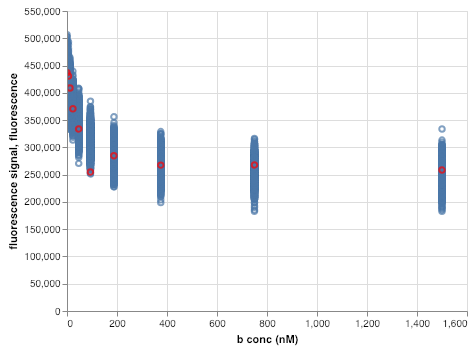

In [29]:
check_ppc(df_good)

This model is more reminiscent of the original model than the student-t one as it is generating far fewer large outliers, but it still incorporates all our data.

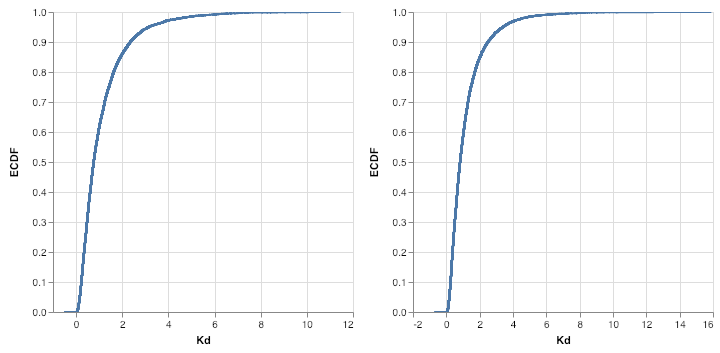

In [30]:
make_ecdf(df_good, "Kd:Q") | make_ecdf(dfmcmc, "Kd:Q")

These also look very similar. Let's report the value of the median:

In [31]:
Kd3 = df_good["Kd"].median()
Kd3

0.7629133532748604

Finally, let's report the values predicted for Kd by each of the models we used to compare:

In [32]:
df_res = pd.DataFrame(columns=['method', 'hbd_low', 'median', 'hbd_high'])
kd_samples = samples2.extract('Kd')['Kd']
df_res = df_res.append(pd.DataFrame({'method': ['mcmc'],
                                     'hbd_low': [bebi103.stan.hpd(kd_samples, mass_frac=0.95)[0]],
                                     'median': [np.median(kd_samples)],
                                     'hbd_high': [bebi103.stan.hpd(kd_samples, mass_frac=0.95)[1]]}),
                      ignore_index=True)
    
kd_samples = samples3.extract('Kd')['Kd']
df_res = df_res.append(pd.DataFrame({'method': ['student_t'],
                                     'hbd_low': [bebi103.stan.hpd(kd_samples, mass_frac=0.95)[0]],
                                     'median': [np.median(kd_samples)],
                                     'hbd_high': [bebi103.stan.hpd(kd_samples, mass_frac=0.95)[1]]}),
                      ignore_index=True)
    
kd_samples = samples4.extract('Kd')['Kd']
df_res = df_res.append(pd.DataFrame({'method': ['good_bad'],
                                     'hbd_low': [bebi103.stan.hpd(kd_samples, mass_frac=0.95)[0]],
                                     'median': [np.median(kd_samples)],
                                     'hbd_high': [bebi103.stan.hpd(kd_samples, mass_frac=0.95)[1]]}),
                      ignore_index=True)


    
# Take a look
df_res

method   hbd_low    median  hbd_high
0       mcmc  0.032054  0.823722  3.412379
1  student_t  0.025724  0.806085  3.382343
2   good_bad  0.041033  0.762913  3.171759

The good_bad model has a tighter distribution of Kd values than either of the other two models, and the median value for Kd is lower for the good_bad model than the other two. The student_t model and the original model yield very similar values for Kd.

Finally, I will print all the stan code used here.

In [33]:
print("-------------MODEL CHECK 1-------------")
print(sm.model_code)
print("-------------MODEL CHECK 2-------------")
print(sm2.model_code)
print("-------------MODEL CHECK 3-------------")
print(sm3.model_code)
print("-------------MODEL CHECK 4-------------")
print(sm4.model_code)

-------------MODEL CHECK 1-------------
data{
    int N;
    real cb[N];
}

generated quantities{
    // Parameters
    real Delta_G;
    real<lower=0> Kd;
    real<lower=0> f0;
    real<lower=0> fq;
    real<lower=0> sigma;

    real<lower=0> ca;
    vector[N] F;
    vector[N] fl;
       
    Delta_G = normal_rng(0,1); 
    Kd = exp(Delta_G);
    f0 = normal_rng(10000, 1000);
    fq = normal_rng(5000, 500);
    sigma = fabs(normal_rng(0, 5000));

    ca = 50;
    
    // Data
    for (i in 1:N) {
        F[i] = f0 * ca - (2 * (f0 - fq) * ca * cb[i]) / (Kd + ca + cb[i] + sqrt(square(Kd + ca + cb[i]) - 4 * ca * cb[i]));
        fl[i] = normal_rng(F[i], sigma);
    }
}
-------------MODEL CHECK 2-------------
data{
    int N;
    real cb[N];
    real fl[N];
    
}

parameters{
    real Delta_G;
    real f0;
    real fq;

    real<lower=0> sigma;
}

transformed parameters{
    real Kd;
    real F[N];
    
    Kd = exp(Delta_G);
    for (i in 1:N) {
        F[i] = f0 * 50 - (2 * (f0 - fq) *